# Checking the usage of the wcs module and sip function

At first, we load the data and reduce the data to those observed in the overlap region. In this note, we describe the focal-plane position in units of pixel instead of um.

In [1]:
import astropy.io.ascii as asc
import astropy.units as u
from astropy.table import unique
import numpy as np
import matplotlib.pylab as plt
import warpfield as wf

f=wf.Optics.focal_length*u.m
scale=(1.*u.um/f*180./np.pi).si.value*u.deg/u.um

pix_size = 15.*u.um

objects = asc.read('case7_challenge_00.txt') #consists of x (um), y (um), catalog_id, ra (deg), dec (deg), and field.
pointings = asc.read('case7_challenge_00_pointing.txt') # consists of field, ra (deg), dec (deg), and pa (deg).

objects['x'] = (objects['x']/pix_size).si
objects['y'] = (objects['y']/pix_size).si
# objects: x (px), y (px), catalog_id, ra (deg), dec (deg), and field.
# pointings: field, ra (deg), dec (deg), and pa (deg).

ids = unique(objects, keys='catalog_id')['catalog_id']
objects.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(objects['catalog_id']==ids[i])
    objects['id'][pos] = i

objects.remove_column('catalog_id')
objects.rename_column('id', 'catalog_id')

true_radec = objects['catalog_id', 'ra', 'dec'].copy()
true_radec.sort('catalog_id')
true_radec = unique(true_radec, keys='catalog_id') # consists of catalog_id, ra (deg), and dec (deg).

observed_xy = objects['field', 'x', 'y', 'catalog_id', 'ra', 'dec'].copy()
observed_xy.rename_column('ra', 'ra_est')
observed_xy.rename_column('dec', 'dec_est')
# observed_xy will have field, x (px), y (px), catalog_id, and estimated ra/dec (deg).

# initializing ra_est and dec_est
observed_xy['ra_est']  = 0.0
observed_xy['dec_est'] = 0.0

field_params = pointings.copy() # field, ra (deg), dec (deg), and pa (deg).

true_radec_overlap = true_radec.copy()
observed_xy_overlap = observed_xy.copy()
for cid in true_radec['catalog_id']:
    if np.count_nonzero(observed_xy['catalog_id']==cid)!=4:
        pos = np.where(true_radec_overlap['catalog_id']==cid)[0]
        true_radec_overlap.remove_rows(pos)
        pos = np.where(observed_xy_overlap['catalog_id']==cid)[0]
        observed_xy_overlap.remove_rows(pos)

ids = unique(true_radec_overlap, keys='catalog_id')['catalog_id']
true_radec_overlap.add_column(-1, name='id')
observed_xy_overlap.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(true_radec_overlap['catalog_id']==ids[i])
    true_radec_overlap['id'][pos] = i
    pos = np.where(observed_xy_overlap['catalog_id']==ids[i])
    observed_xy_overlap['id'][pos] = i

true_radec_overlap.remove_column('catalog_id')
true_radec_overlap.rename_column('id', 'catalog_id')
observed_xy_overlap.remove_column('catalog_id')
observed_xy_overlap.rename_column('id', 'catalog_id')

Let's check the distribution.

Text(0, 0.5, 'dec (deg)')

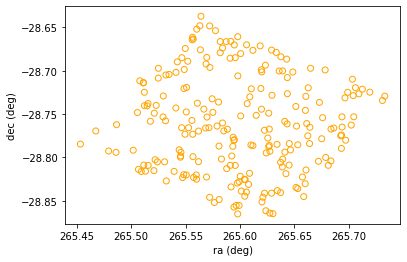

In [2]:
import matplotlib.pylab as plt

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='o', facecolor='None', edgecolor='orange')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

Here, we define a function to generate wcs instance.

In [3]:
from astropy.wcs import WCS
from astropy.wcs import Sip
import astropy.units as u

def wcs(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[np.cos(pa_ptg*u.deg), -np.sin(pa_ptg*u.deg)],
              [np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
#    if a is not None and b is not None:
    w.sip = Sip(a, b, ap, bp, [0, 0])
    
    return w

In addition, we define a function which calculates x/y from the field parameters and ra/dec values of objects.

In [4]:
def xy_calculator(observed_xy, field_params, plate_scale, ap, bp, radec_info):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    observed_xy_cp = observed_xy.copy()
    observed_xy_cp.rename_column('x', 'x_est')
    observed_xy_cp.rename_column('y', 'y_est')
    observed_xy_cp['x_est']   = None
    observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None

    for i in range(0, np.size(radec_info)):
        pos = np.where(observed_xy_cp['catalog_id']==radec_info[i]['catalog_id'])
        observed_xy_cp['ra_est'][pos]  = radec_info[i]['ra_est']
        observed_xy_cp['dec_est'][pos] = radec_info[i]['dec_est']
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, ap=ap, bp=bp)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        radec0 = np.concatenate(([observed_xy_cp[pos]['ra_est']], [observed_xy_cp[pos]['dec_est']])).T
        ret = w.sip_foc2pix(w.wcs_world2pix(radec0, 1)-w.wcs.crpix, 1)
        # The origin setting is very important.
        observed_xy_cp['x_est'][pos] = ret[:, 0]
        observed_xy_cp['y_est'][pos] = ret[:, 1]

    return observed_xy_cp['x_est', 'y_est']

## Check 1: Calculation w/o distortion

We make an array 'radec0' which is a copy of 'true_radec_overlap' but has 'ra_est' and 'dec_est' instead of 'ra' and 'dec', respectively.

In [5]:
radec0 = true_radec_overlap.copy()
radec0.rename_column('ra', 'ra_est')
radec0.rename_column('dec', 'dec_est')

Then, we calculate x/y values from radec0. Here, we set ap and bp to be zero matrices.

In [6]:
ret = xy_calculator(observed_xy_overlap, field_params, ((scale/(u.deg/u.um))*pix_size/u.um).si.value,\
                    np.zeros(shape=(3,3)), np.zeros(shape=(3,3)), radec0)

Let's check the results.

In [7]:
xy = observed_xy_overlap.copy()
xy.add_column(ret['x_est'], name='x_calc')
xy.add_column(ret['y_est'], name='y_calc')

### Distribution on the focal plane (x/y values)

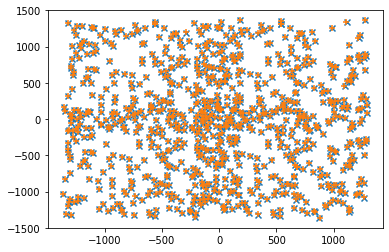

In [8]:
plt.scatter(xy['x'], xy['y'], marker='x')
plt.scatter(xy['x_calc'], xy['y_calc'], marker='+')

### Difference between the calculated values and true values

Text(0, 0.5, 'dy (px)')

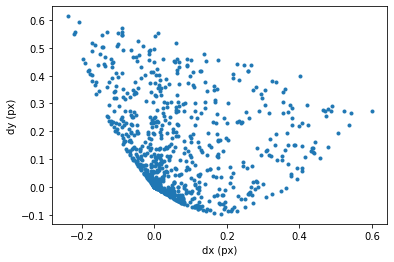

In [9]:
plt.scatter(xy['x_calc']-xy['x'], xy['y_calc']-xy['y'], marker='.')
plt.xlabel('dx (px)')
plt.ylabel('dy (px)')

In this calculation, the distortion is not considered. Therefore, the observed difference is thought to be caused by the distortion.

## Check 2: Calculation w/ distortion

Here, we consider the distortion. The coefficients for describing the distortion is written in the meta part of case7_challenge_00.txt. We make sip_c and sip_d matrices based on that description as below. The parameters are scaled with using the pixel size because the original values are defined to handle the focal-plane positions in units of um.

In [10]:
sip_c = np.zeros(shape=(5, 5))
sip_d = np.zeros(shape=(5, 5))
sip_c[0,2]=-2.34153374723336e-09
sip_c[1,1]=1.5792128155073916e-08
sip_c[1,2]=7.674347291529089e-15
sip_c[2,0]=-4.694743859349522e-09
sip_c[2,1]=5.4256004358596465e-15
sip_c[2,2]=-4.6341769281246224e-21
sip_d[0,2]=-1.913280244657798e-08
sip_d[1,1]=-5.622875292409728e-09
sip_d[1,2]=-1.0128311203344238e-14
sip_d[2,0]=3.1424733259527392e-09
sip_d[2,1]=-9.08024075521211e-15
sip_d[2,2]=-1.4123037013352912e-20
m, n = np.indices((5, 5))
mn = m + n
fct = ((pix_size/u.um).si.value)**(mn-1)
sip_c = sip_c * fct
sip_d = sip_d * fct

Then, we calculate x/y values again. But this time, we use sip_c and sip_d matrices as ap and bp matrices.

In [11]:
ret = xy_calculator(observed_xy_overlap, field_params, ((scale/(u.deg/u.um))*pix_size/u.um).si.value,\
                    sip_c, sip_d, radec0)

The comparison between the calculated x/y values and the true x/y values are shown as below.

In [12]:
xy = observed_xy_overlap.copy()
xy.add_column(ret['x_est'], name='x_calc')
xy.add_column(ret['y_est'], name='y_calc')

### Distribution on the focal plane (x/y values)

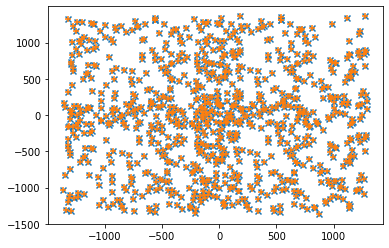

In [13]:
plt.scatter(xy['x'], xy['y'], marker='x')
plt.scatter(xy['x_calc'], xy['y_calc'], marker='+')

### Difference between the calculated values and true values

Text(0, 0.5, 'dy (px)')

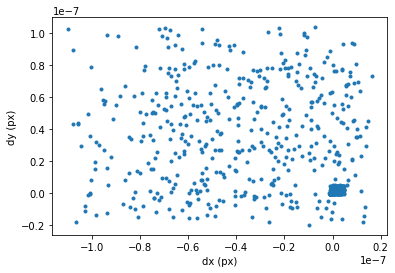

In [14]:
plt.scatter(xy['x_calc']-xy['x'], xy['y_calc']-xy['y'], marker='.')
plt.xlabel('dx (px)')
plt.ylabel('dy (px)')

We can see that the difference is significantly reduced by considering the distortion. We expect that the distortion is correctly treated by the sip functions in the wcs module.